In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from src.model import GPT

model = GPT.from_pretrained("gpt2")
pos_old = np.load("out/decompositions/openwebtext-gpt2/pos_id1-512_none_train.npy")
pos = np.load("out/gpt2-openwebtext/pos_id1-512_none_train.npy")
L, types, T, C = pos.shape
N = 32 * T
cvec = np.memmap(
    "out/gpt2-openwebtext/cvec_id1-512_none_train.npy",
    mode="r",
    shape=(L, types, N, C),
    dtype=np.float32,
)

pos_old.shape, pos.shape, cvec.shape

((13, 511, 768), (12, 6, 511, 768), (12, 6, 16352, 768))

### Outliers match

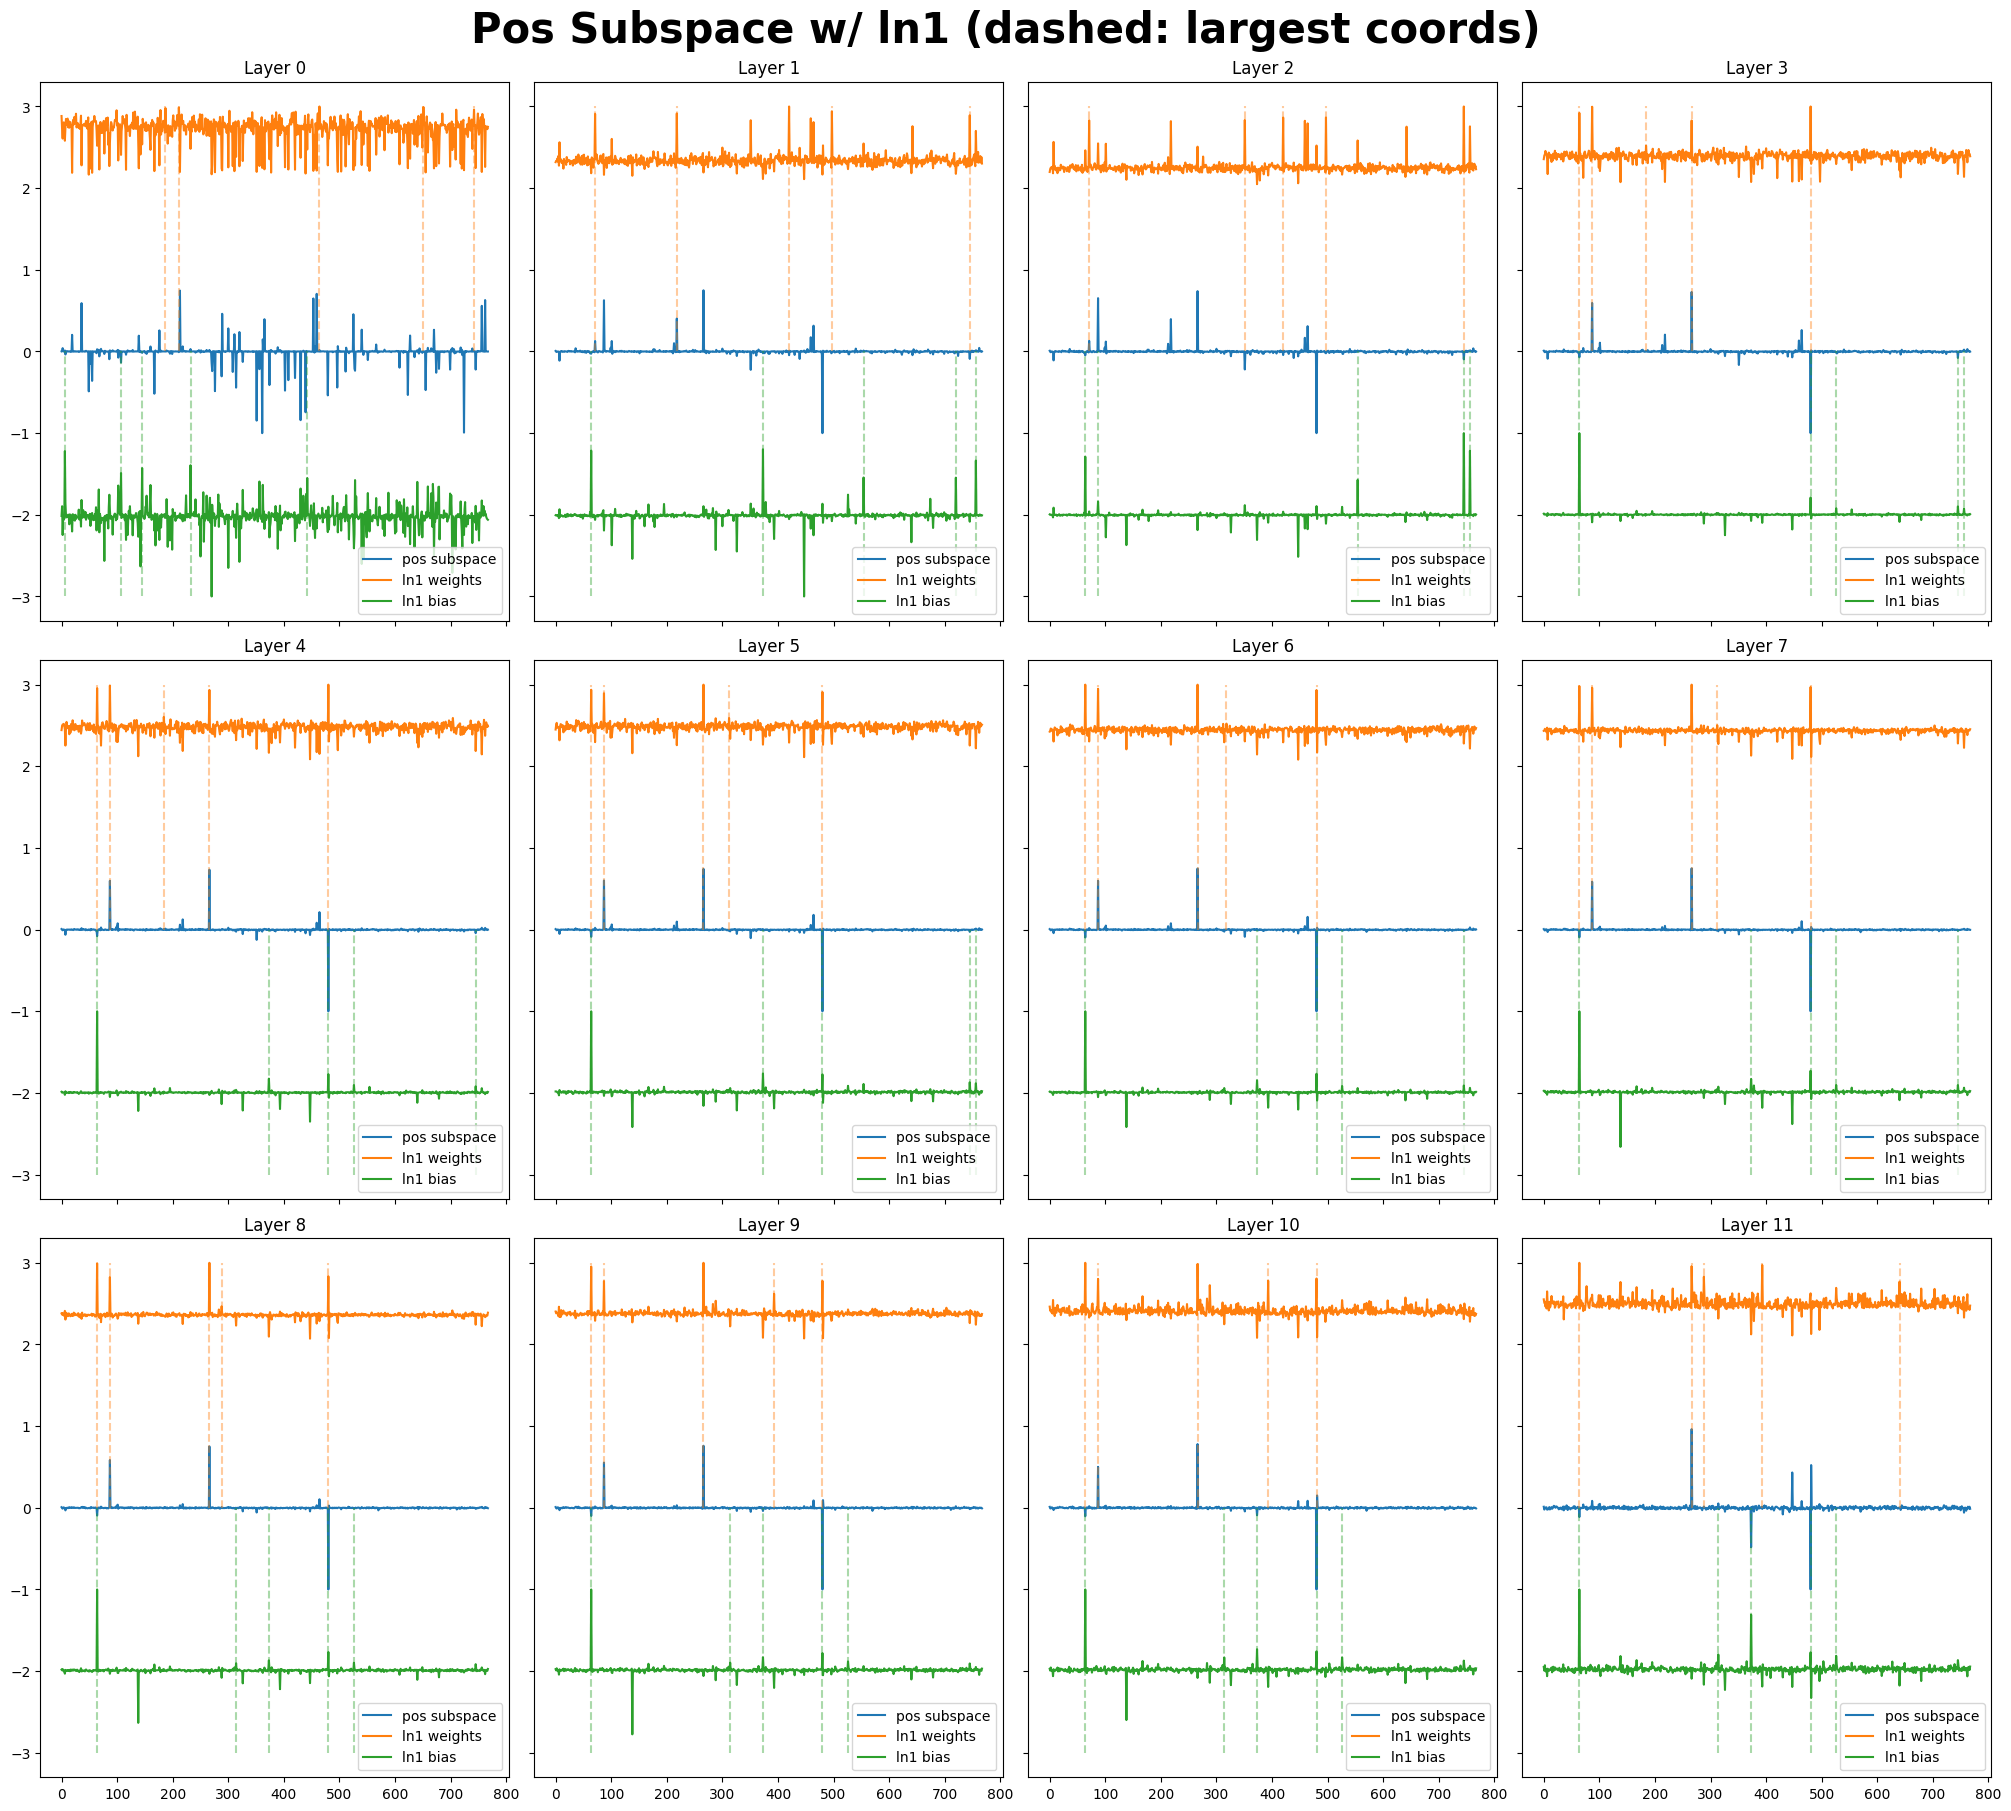

In [2]:
fig, axs = plt.subplots(3, 4, figsize=(20, 18), constrained_layout=True, sharex=True, sharey=True)
for layer in range(12):
    if layer == 0:
        p = pos_old[0]
    else:
        p = pos[layer - 1, 5]
    U, s, Vt = np.linalg.svd(p)
    
    v = Vt[0]
    v = v / np.abs(v).max()

    w = model.transformer.h[layer].ln_1.weight.numpy(force=True)
    w = w / np.abs(w).max()
    w_list_max = np.argsort(w)[::-1]

    b = model.transformer.h[layer].ln_1.bias.numpy(force=True)
    b = b / np.abs(b).max()
    b_list_max = np.argsort(b)[::-1]

    ax = axs[layer // 4, layer % 4]
    ax.plot(v, label="pos subspace")
    ax.plot(w + 2, label="ln1 weights")
    ax.plot(b - 2, label="ln1 bias")
    ax.vlines(w_list_max[:5], linestyle="dashed", ymin=0, ymax=3, alpha=0.4, color="#ff7f0e")
    ax.vlines(b_list_max[:5], linestyle="dashed", ymin=-3, ymax=0, alpha=0.4, color="#2ca02c")
    ax.legend(loc="lower right")
    ax.set_title(f"Layer {layer}")

fig.suptitle("Pos Subspace w/ ln1 (dashed: largest coords)", fontsize=30, fontweight="bold")
plt.savefig("pos-ln1.png")
plt.show()

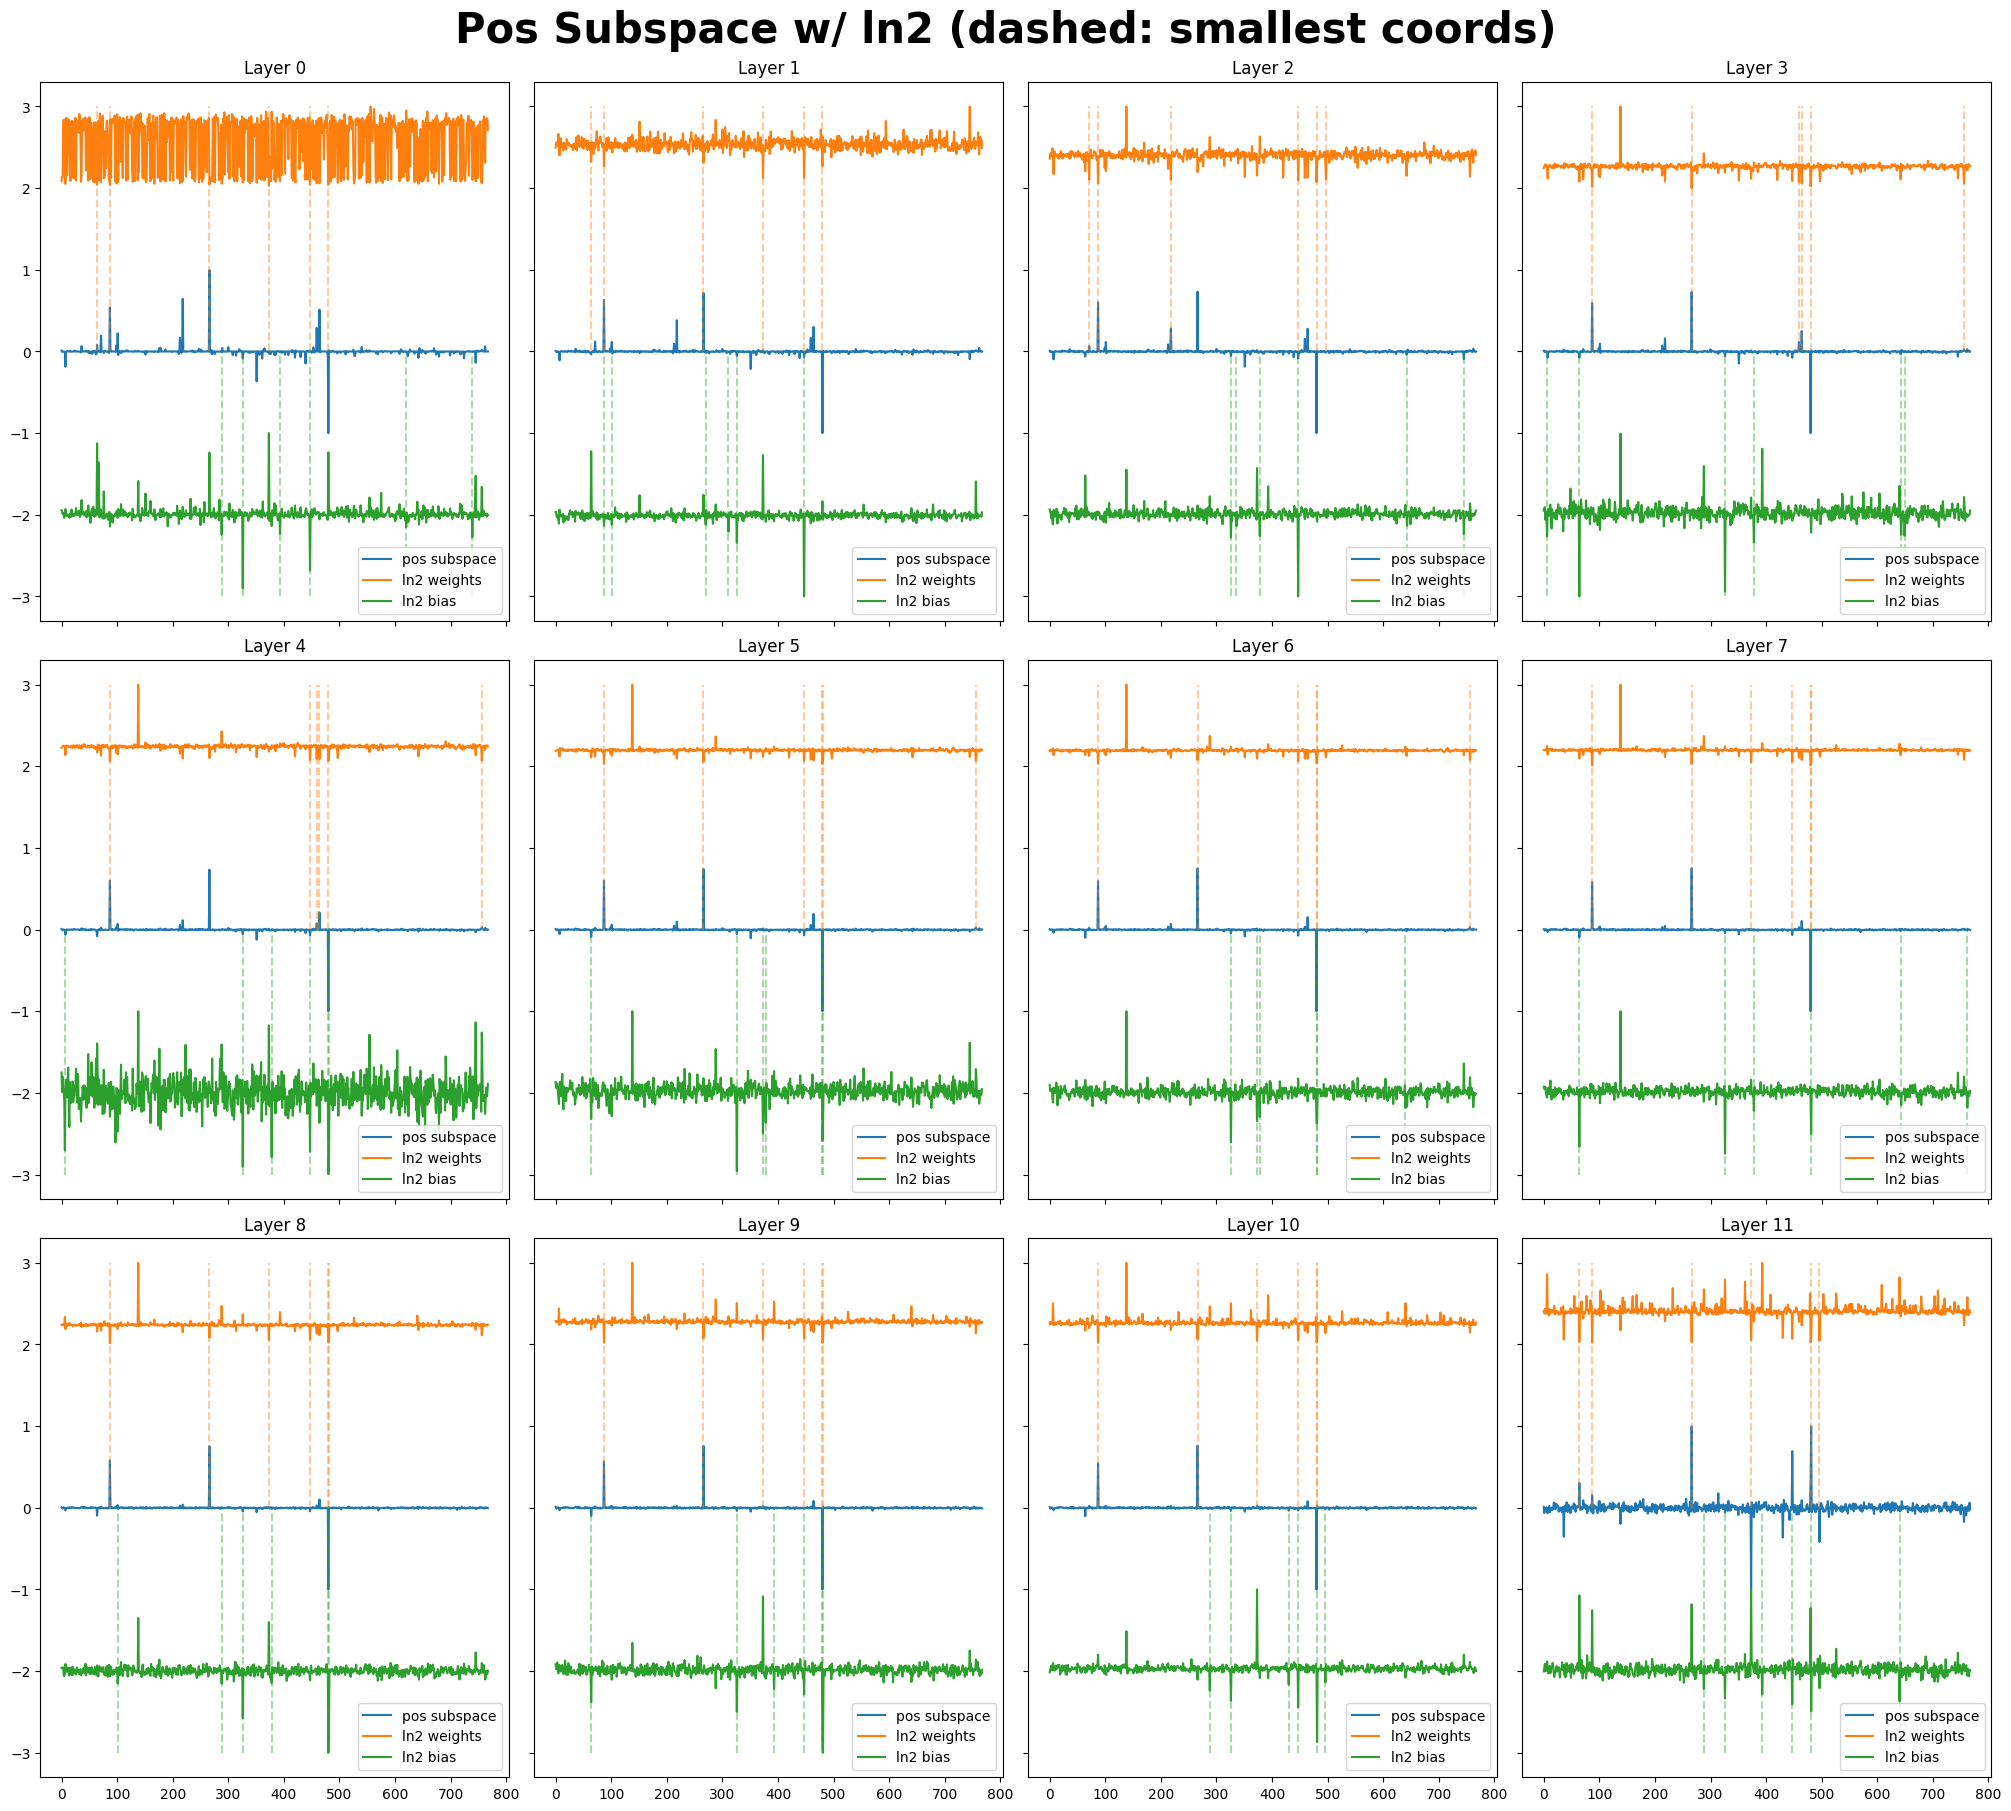

In [3]:
fig, axs = plt.subplots(3, 4, figsize=(20, 18), constrained_layout=True, sharex=True, sharey=True)
for layer in range(12):
    p = pos[layer, 2]
    U, s, Vt = np.linalg.svd(p)
    
    v = Vt[0]
    v = v / np.abs(v).max()

    w = model.transformer.h[layer].ln_2.weight.numpy(force=True)
    w = w / np.abs(w).max()
    w_list_max = np.argsort(w)

    b = model.transformer.h[layer].ln_2.bias.numpy(force=True)
    b = b / np.abs(b).max()
    b_list_max = np.argsort(b)

    ax = axs[layer // 4, layer % 4]
    ax.plot(v, label="pos subspace")
    ax.plot(w + 2, label="ln2 weights")
    ax.plot(b - 2, label="ln2 bias")
    ax.vlines(w_list_max[:6], linestyle="dashed", ymin=0, ymax=3, alpha=0.4, color="#ff7f0e")
    ax.vlines(b_list_max[:6], linestyle="dashed", ymin=-3, ymax=0, alpha=0.4, color="#2ca02c")
    ax.legend(loc="lower right")
    ax.set_title(f"Layer {layer}")

fig.suptitle("Pos Subspace w/ ln2 (dashed: smallest coords)", fontsize=30, fontweight="bold")
plt.savefig("pos-ln2.png")
plt.show()

### Before and After layer normalization

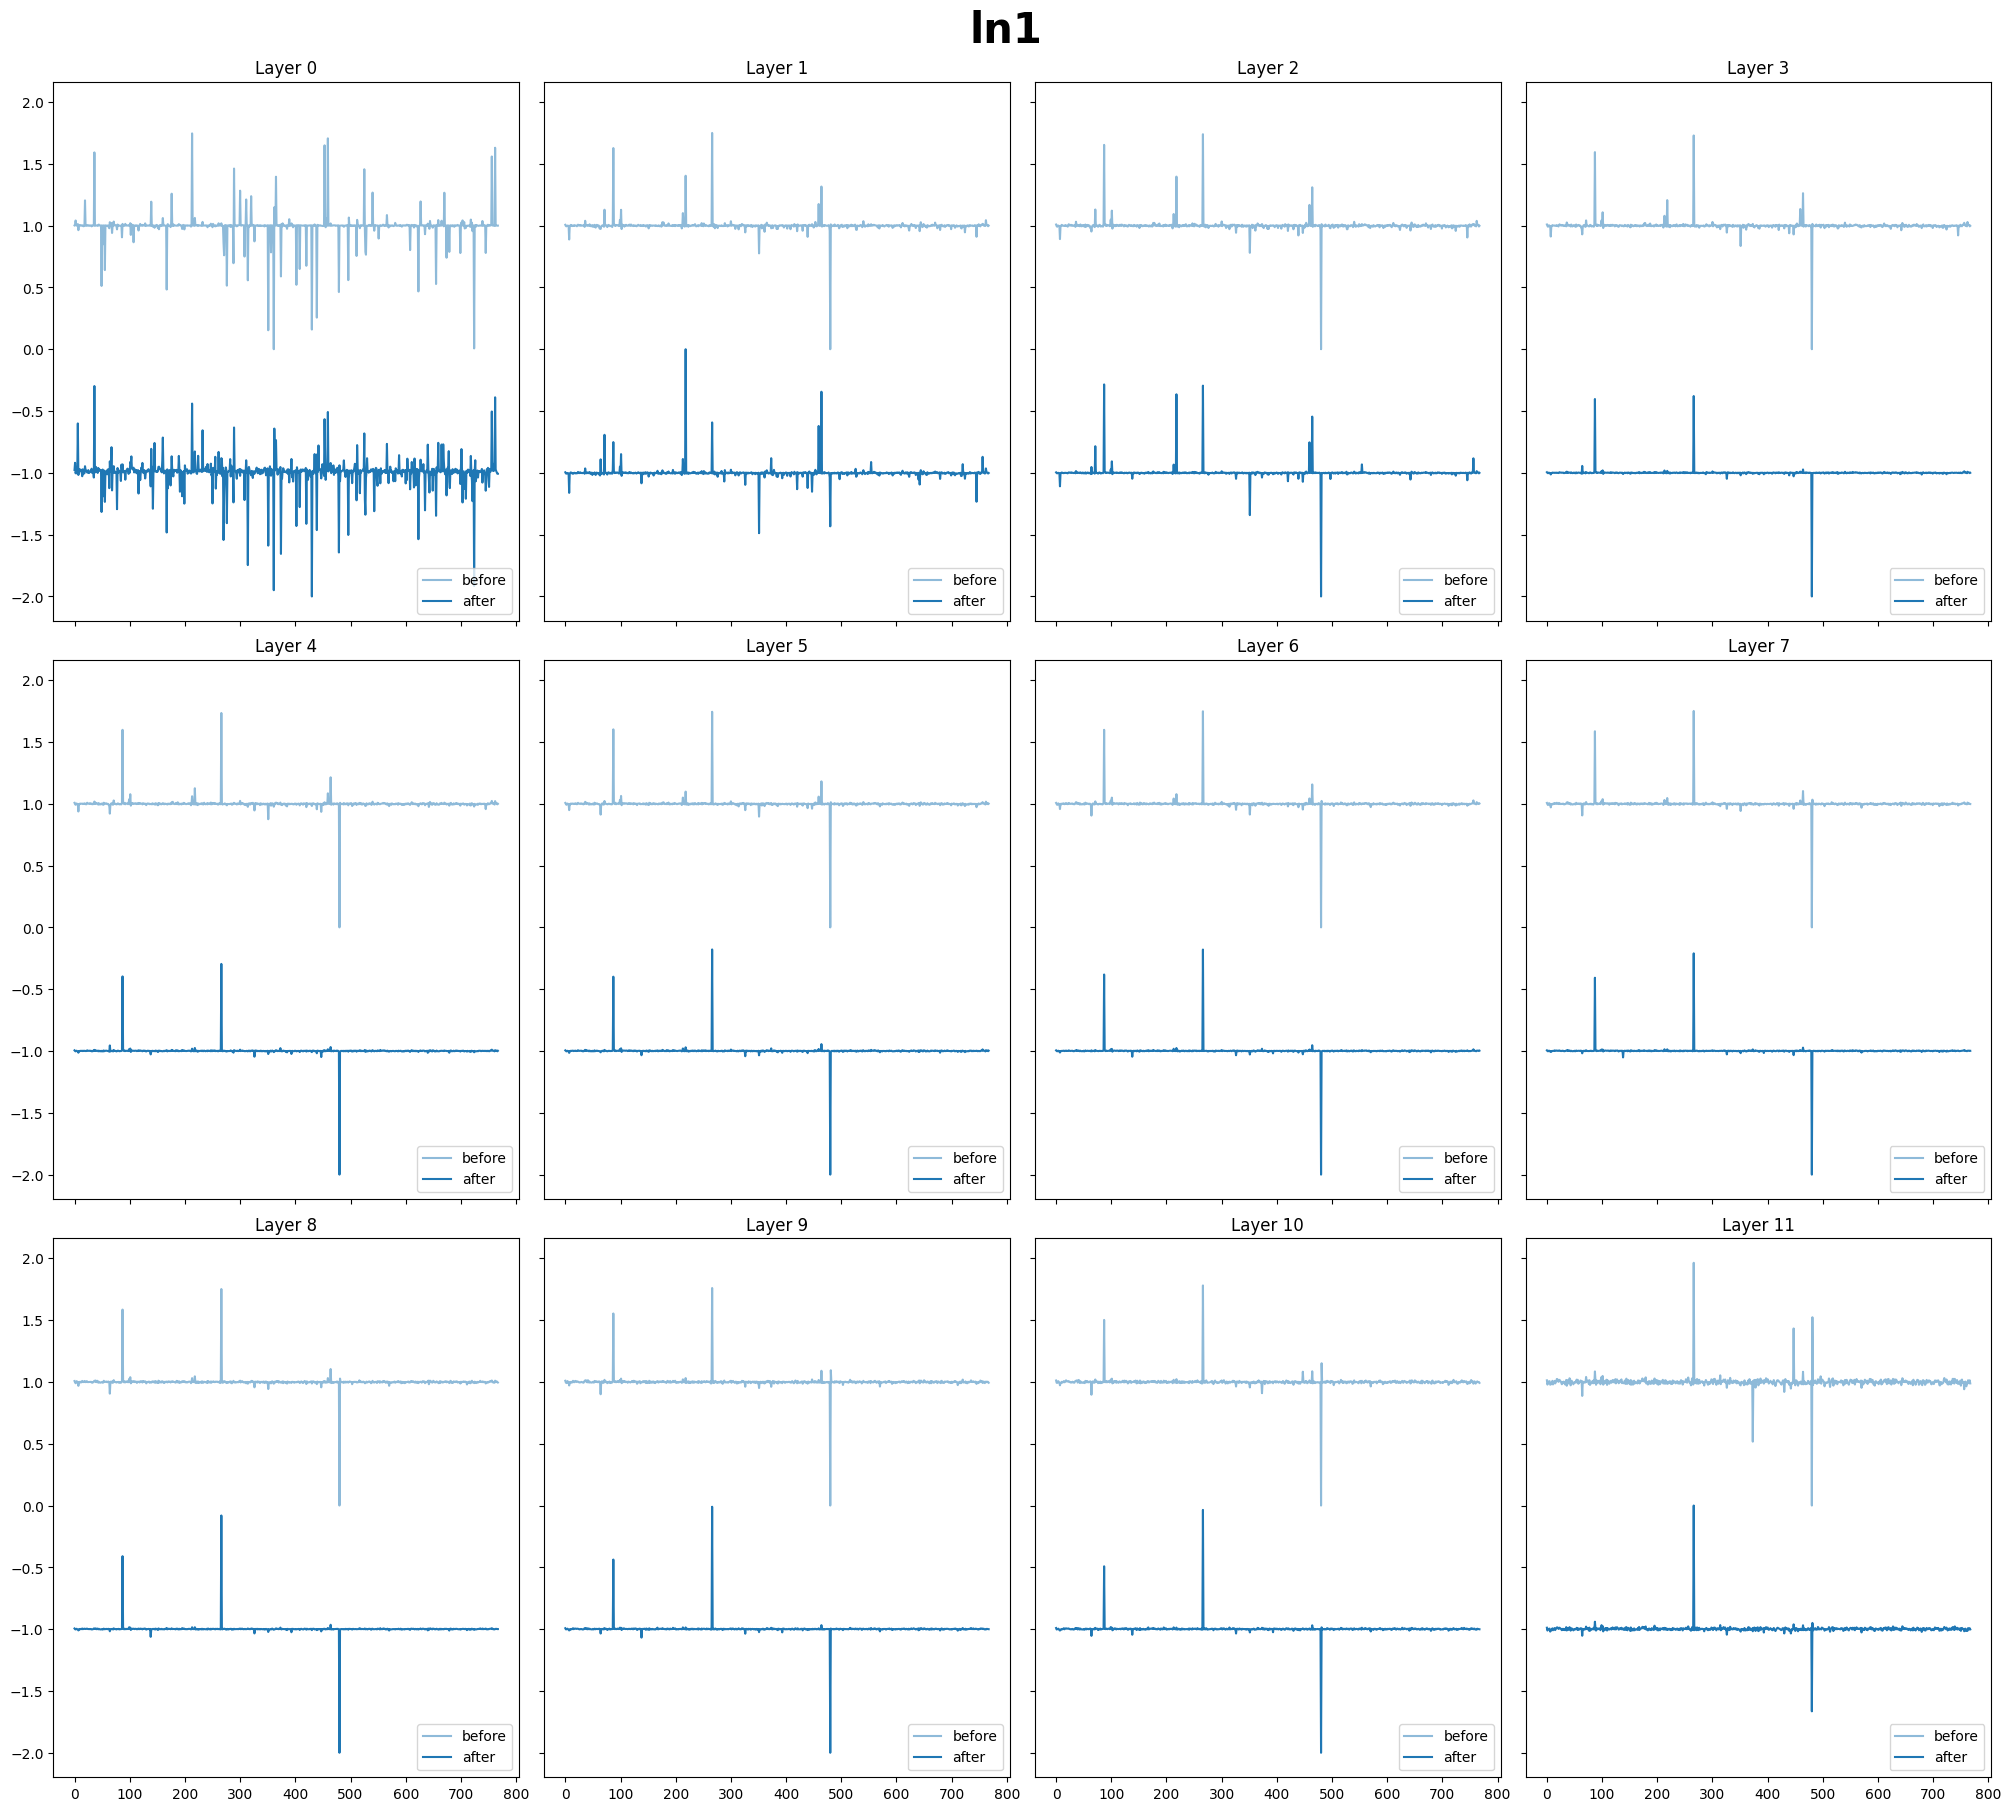

In [20]:
fig, axs = plt.subplots(3, 4, figsize=(20, 18), constrained_layout=True, sharex=True, sharey=True)
for layer in range(12):
    if layer == 0:
        p = pos_old[0]
    else:
        p = pos[layer - 1, 5]
    U, s, Vt = np.linalg.svd(p)
    
    v = Vt[0]
    ln = model.transformer.h[layer].ln_1
    vv = ln(torch.tensor(v)).numpy(force=True)

    v = v / np.abs(v).max()
    vv = vv / np.abs(vv).max()

    ax = axs[layer // 4, layer % 4]
    ax.plot(v + 1, label="before", c="#1f77b4", alpha=0.5)
    ax.plot(vv - 1, label="after", c="#1f77b4")
    ax.legend(loc="lower right")
    ax.set_title(f"Layer {layer}")

fig.suptitle("ln1", fontsize=30, fontweight="bold")
plt.savefig("ln1-before-after.png")
plt.show()

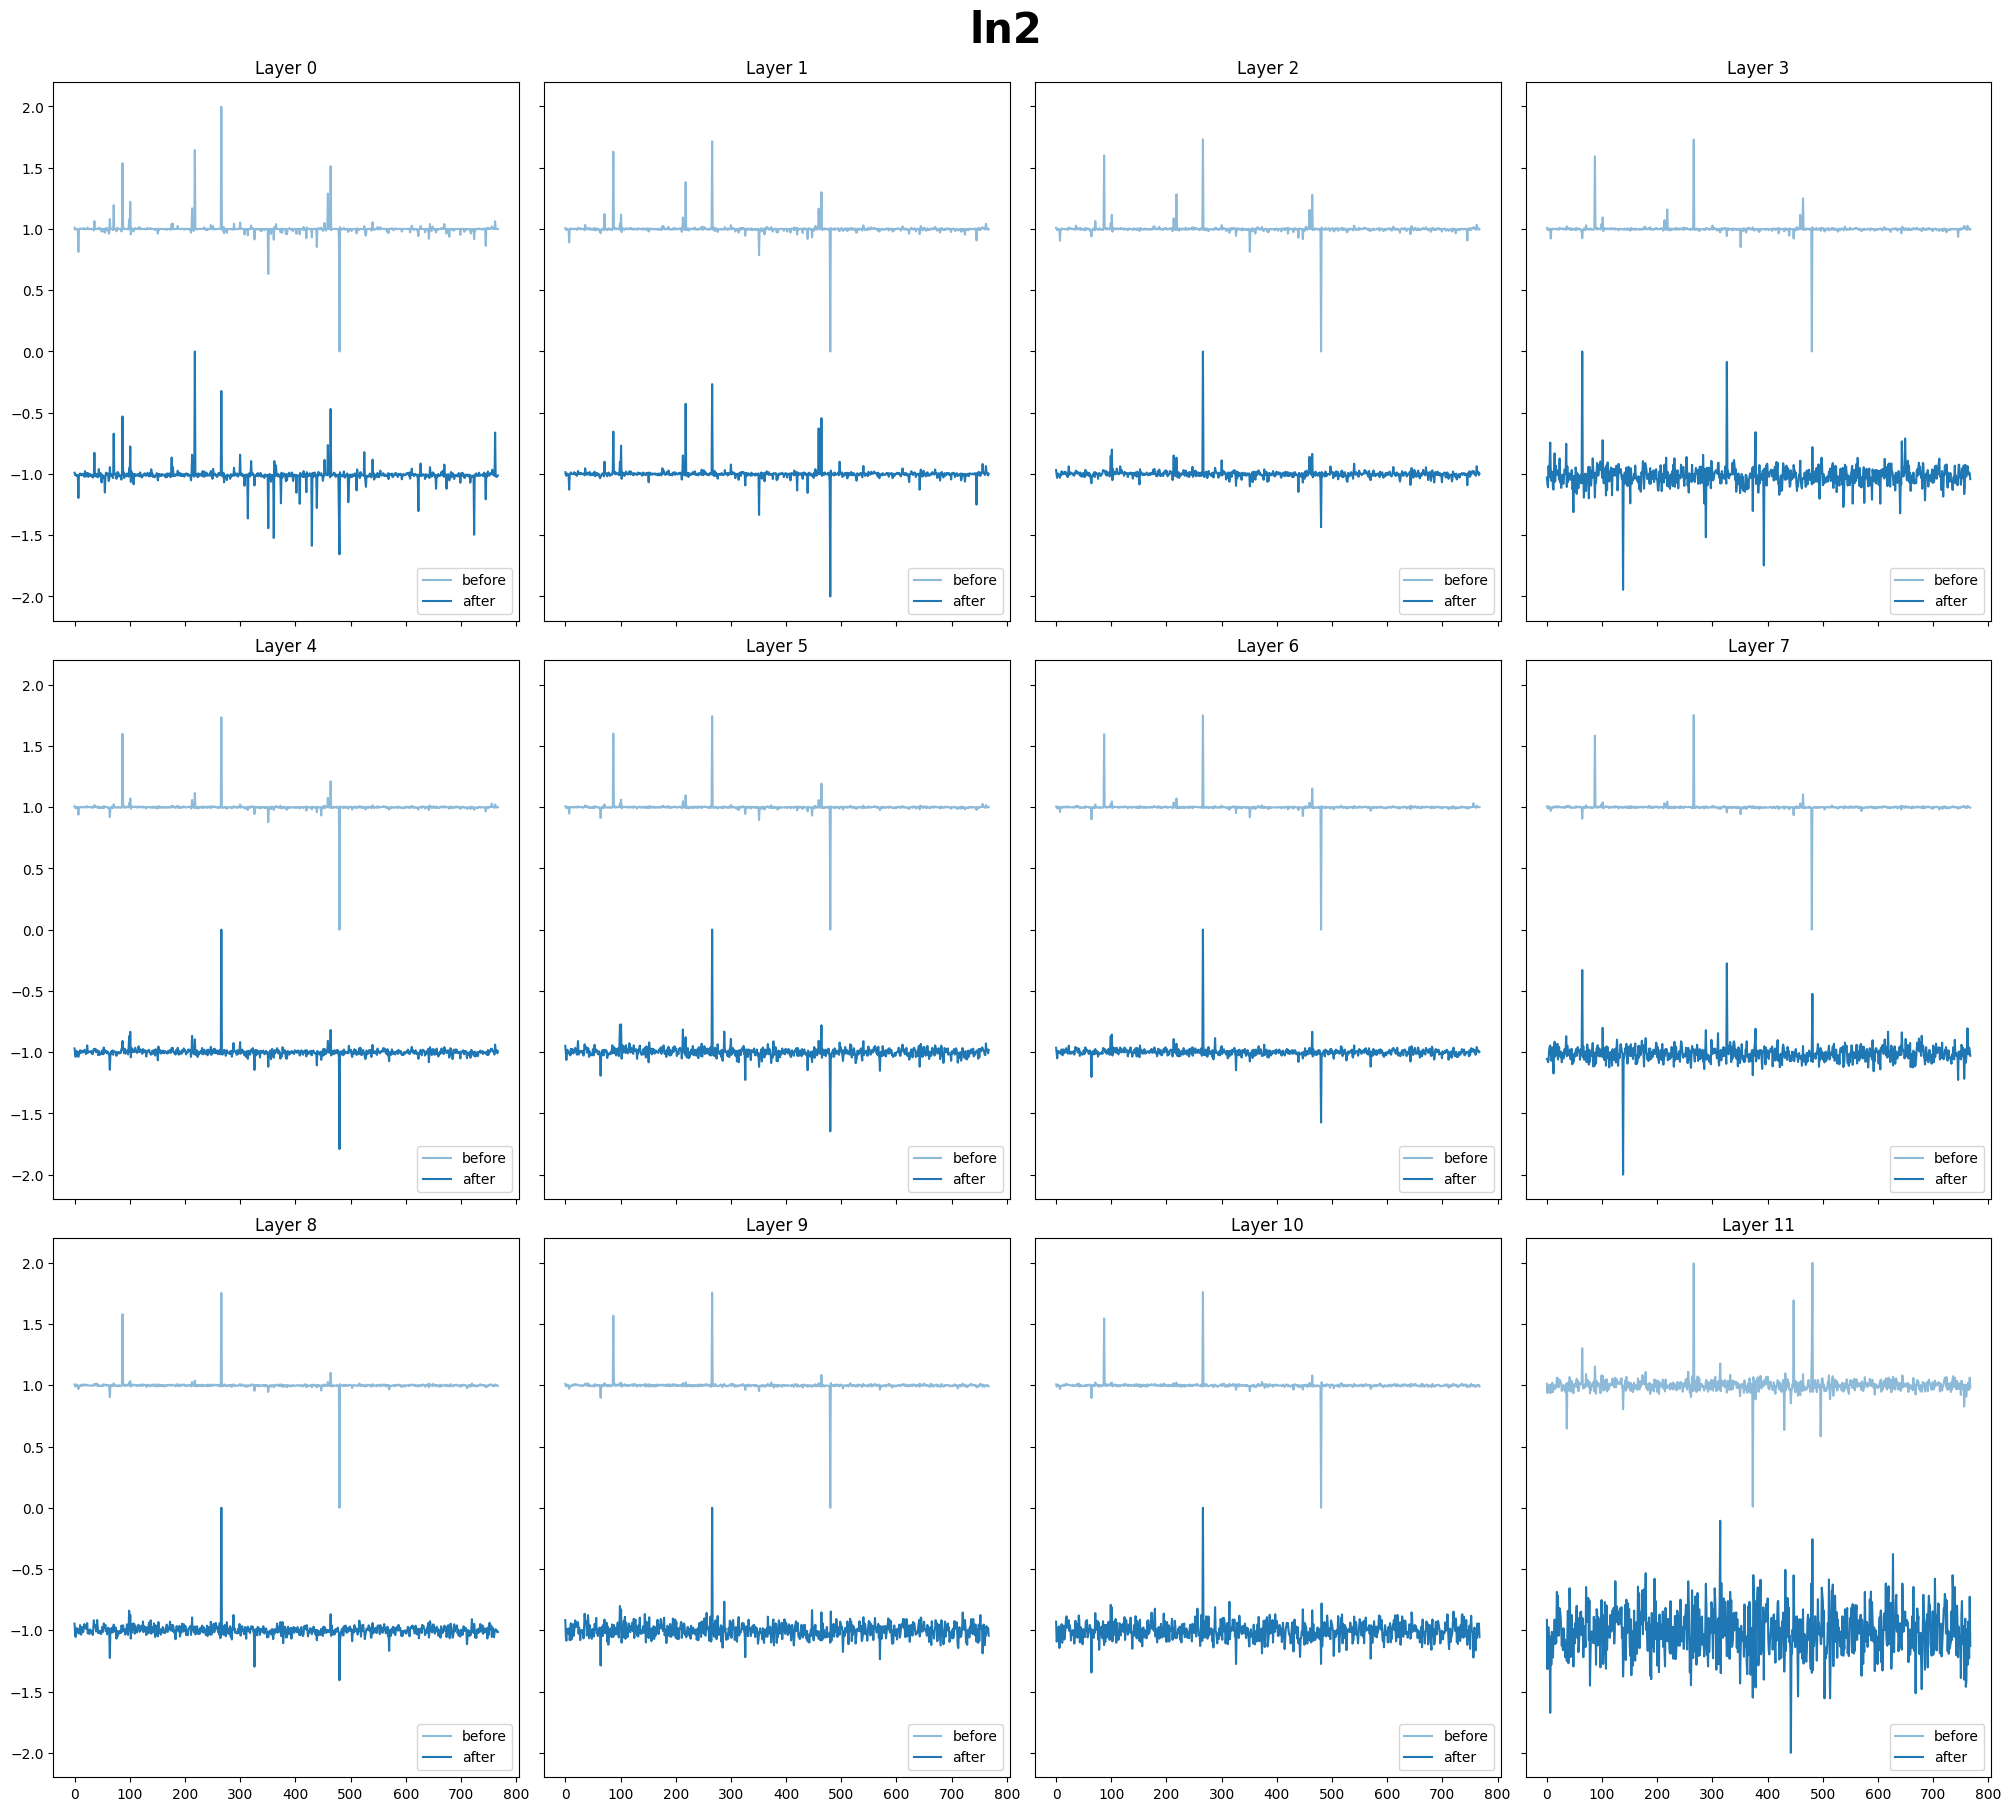

In [21]:
fig, axs = plt.subplots(3, 4, figsize=(20, 18), constrained_layout=True, sharex=True, sharey=True)
for layer in range(12):
    p = pos[layer, 2]
    U, s, Vt = np.linalg.svd(p)
    v = Vt[0]

    ln = model.transformer.h[layer].ln_2
    pp = ln(torch.tensor(p)).numpy(force=True)
    U, s, Vt = np.linalg.svd(pp)
    vv = Vt[0]

    v = v / np.abs(v).max()
    vv = vv / np.abs(vv).max()

    ax = axs[layer // 4, layer % 4]
    ax.plot(v + 1, label="before", c="#1f77b4", alpha=0.5)
    ax.plot(vv - 1, label="after", c="#1f77b4")
    ax.legend(loc="lower right")
    ax.set_title(f"Layer {layer}")

fig.suptitle("ln2", fontsize=30, fontweight="bold")
plt.savefig("ln2-before-after.png")
plt.show()

## Sim w/ largest of LN1 (only largest 10 coords are kept)

In [6]:
def cosine_sim(x, y):
    return x.T @ y / (np.linalg.norm(x) * np.linalg.norm(y))


def sample():
    batch_size, block_size = 1, 512
    data = np.memmap("src/data/openwebtext/train_gpt2.bin", dtype=np.uint16, mode="r")
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack(
        [torch.from_numpy((data[i : i + block_size]).astype(np.int64)) for i in ix]
    )
    return x

def plot(sims):
    plt.plot(sims[:, 0], marker="o", label="pos")
    # plt.plot(sims[:, 2], marker="o", label="sampled sentence")
    plt.plot(sims[:, 1], marker="o", label="random vec")
    plt.legend(loc="upper left")
    plt.xticks(ticks=np.arange(len(sims)), labels=1 + np.arange(len(sims)))
    plt.xlabel("layer")

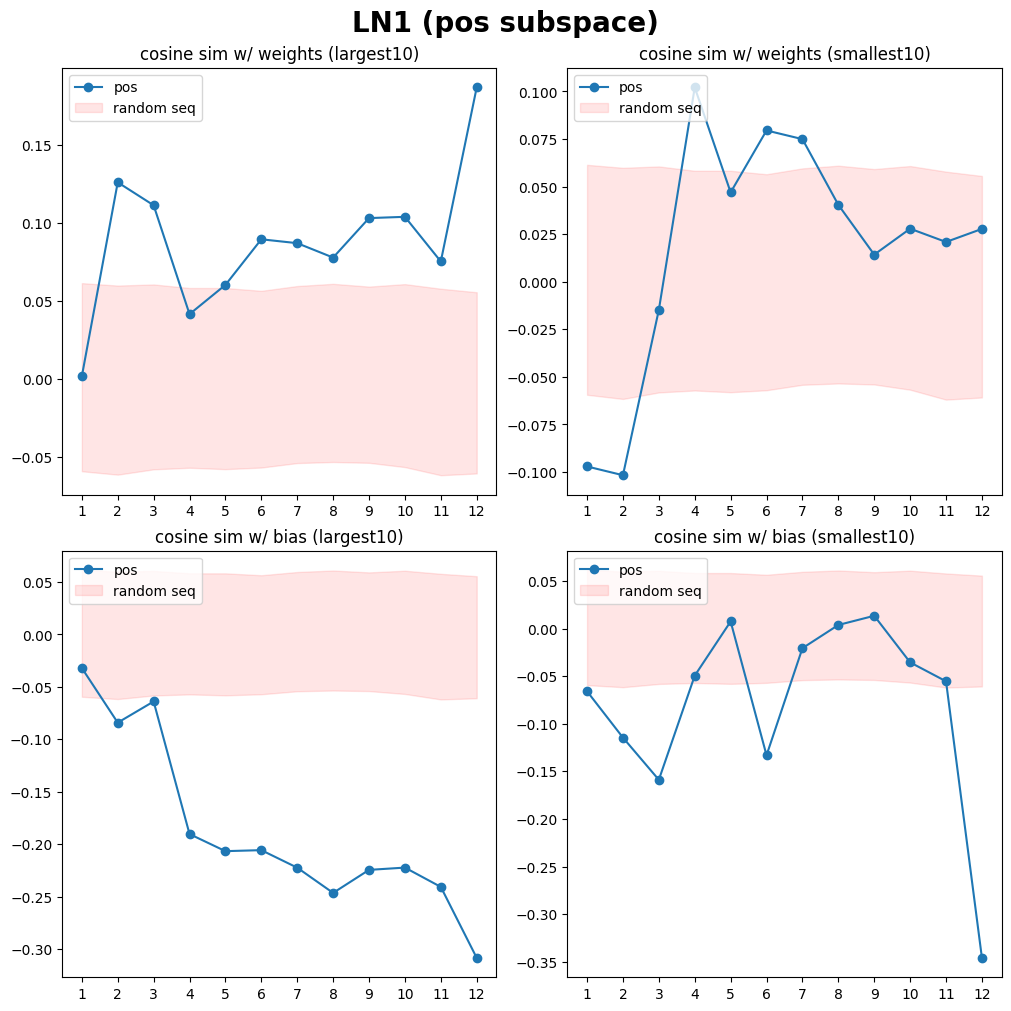

In [8]:
# LN1 weights & bias
sims = np.zeros((12, 6))
for layer in range(12):
    if layer == 0:
        p = pos_old[0]
    else:
        p = pos[layer - 1, 5]
    
    Vt = np.linalg.svd(p)[-1]
    v = Vt[0]

    ln = model.transformer.h[layer].ln_1
    w = ln.weight.numpy(force=True)
    b = ln.bias.numpy(force=True)

    w_L = np.where(w > np.percentile(w, 100 - 10 * 100 / len(w)), w, 0)
    w_S = np.where(w < np.percentile(w, 10 * 100 / len(w)), w, 0)
    b_L = np.where(b > np.percentile(b, 100 - 10 * 100 / len(b)), b, 0)
    b_S = np.where(b < np.percentile(b, 10 * 100 / len(b)), b, 0)

    rs = np.array([cosine_sim(v, np.random.randn(*w.shape)) for _ in range(1000)])
    r_h, r_l = np.percentile(rs, 95, axis=0), np.percentile(rs, 5, axis=0)

    sims[layer] = [
        cosine_sim(v, w_L), cosine_sim(v, w_S),
        cosine_sim(v, b_L), cosine_sim(v, b_S),
        r_h, r_l
    ]

fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
for w_or_b in range(2):
    for l_or_s in range(2):
        ax = axs[w_or_b][l_or_s]
        ax.plot(sims[:, 2*w_or_b+l_or_s], marker="o", label="pos")
        ax.fill_between(np.arange(len(sims)), sims[:, 4], sims[:, 5], label="random seq", color="red", alpha=0.1)
        ax.set_xticks(ticks=np.arange(len(sims)), labels=1 + np.arange(len(sims)))
        ax.legend(loc="upper left")

        name_w_or_b = ["weights", "bias"][w_or_b]
        name_l_or_s = ["largest", "smallest"][l_or_s]
        ax.set_title(f"cosine sim w/ {name_w_or_b} ({name_l_or_s}10)")

plt.suptitle("LN1 (pos subspace)", fontsize=20, fontweight="bold")
plt.savefig("ln1.png")
plt.show()

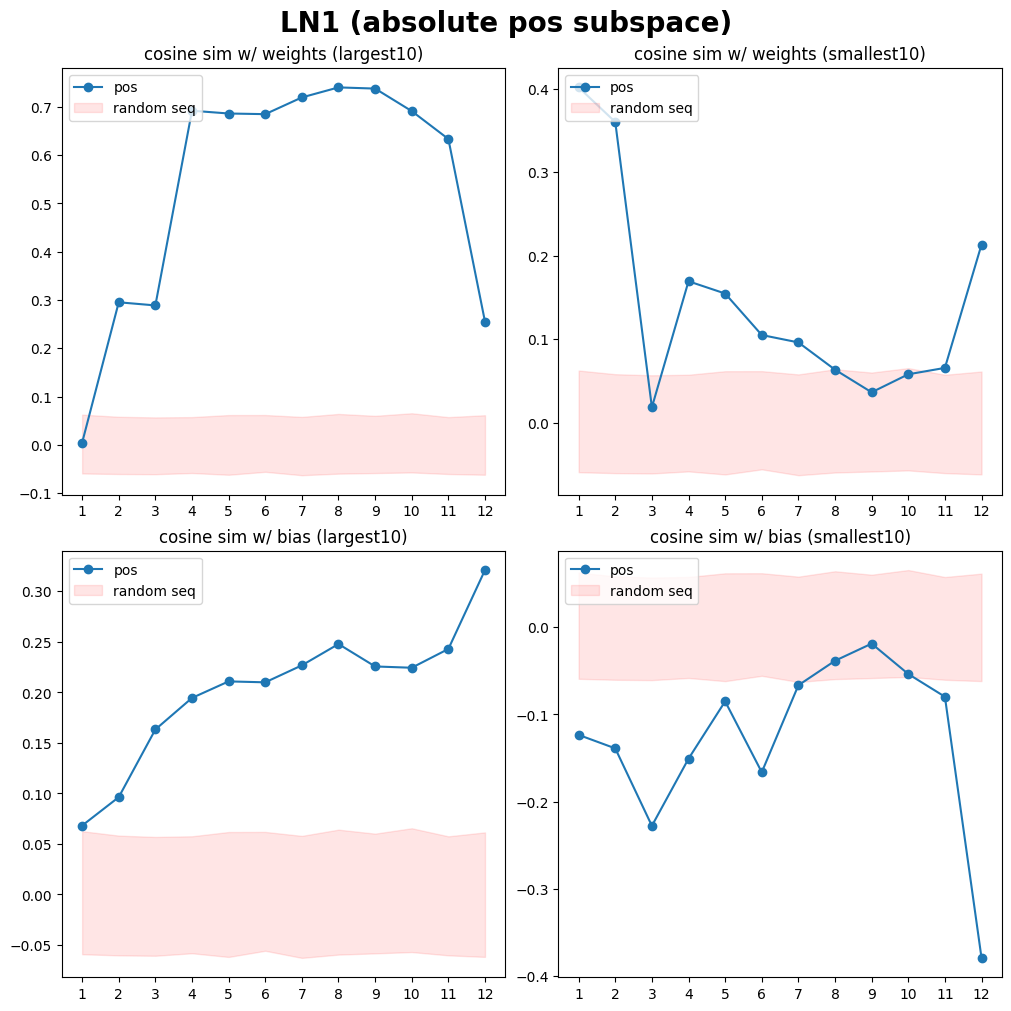

In [9]:
# LN1 weights & bias
sims = np.zeros((12, 6))
for layer in range(12):
    if layer == 0:
        p = pos_old[0]
    else:
        p = pos[layer - 1, 5]
    
    Vt = np.linalg.svd(p)[-1]
    v = np.abs(Vt[0])

    ln = model.transformer.h[layer].ln_1
    w = ln.weight.numpy(force=True)
    b = ln.bias.numpy(force=True)

    w_L = np.where(w > np.percentile(w, 100 - 10 * 100 / len(w)), w, 0)
    w_S = np.where(w < np.percentile(w, 10 * 100 / len(w)), w, 0)
    b_L = np.where(b > np.percentile(b, 100 - 10 * 100 / len(b)), b, 0)
    b_S = np.where(b < np.percentile(b, 10 * 100 / len(b)), b, 0)

    rs = np.array([cosine_sim(v, np.random.randn(*w.shape)) for _ in range(1000)])
    r_h, r_l = np.percentile(rs, 95, axis=0), np.percentile(rs, 5, axis=0)

    sims[layer] = [
        cosine_sim(v, w_L), cosine_sim(v, w_S),
        cosine_sim(v, b_L), cosine_sim(v, b_S),
        r_h, r_l
    ]

fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
for w_or_b in range(2):
    for l_or_s in range(2):
        ax = axs[w_or_b][l_or_s]
        ax.plot(sims[:, 2*w_or_b+l_or_s], marker="o", label="pos")
        ax.fill_between(np.arange(len(sims)), sims[:, 4], sims[:, 5], label="random seq", color="red", alpha=0.1)
        ax.set_xticks(ticks=np.arange(len(sims)), labels=1 + np.arange(len(sims)))
        ax.legend(loc="upper left")

        name_w_or_b = ["weights", "bias"][w_or_b]
        name_l_or_s = ["largest", "smallest"][l_or_s]
        ax.set_title(f"cosine sim w/ {name_w_or_b} ({name_l_or_s}10)")

plt.suptitle("LN1 (absolute pos subspace)", fontsize=20, fontweight="bold")
plt.savefig("ln1_abs.png")
plt.show()

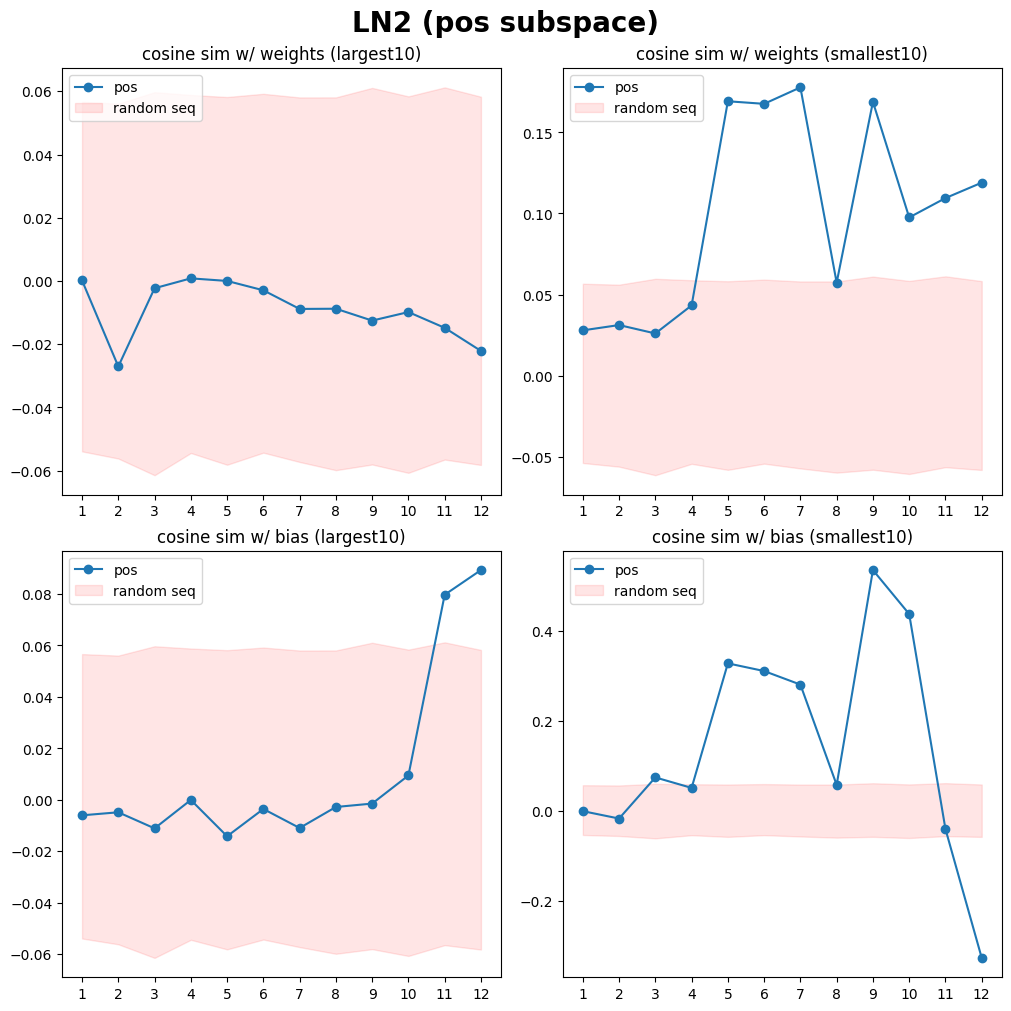

In [10]:
# LN2 weights & bias
sims = np.zeros((12, 6))
for layer in range(12):
    p = pos[layer, 2]
    
    Vt = np.linalg.svd(p)[-1]
    v = Vt[0]

    ln = model.transformer.h[layer].ln_2
    w = ln.weight.numpy(force=True)
    b = ln.bias.numpy(force=True)

    w_L = np.where(w > np.percentile(w, 100 - 10 * 100 / len(w)), w, 0)
    w_S = np.where(w < np.percentile(w, 10 * 100 / len(w)), w, 0)
    b_L = np.where(b > np.percentile(b, 100 - 10 * 100 / len(b)), b, 0)
    b_S = np.where(b < np.percentile(b, 10 * 100 / len(b)), b, 0)

    rs = np.array([cosine_sim(v, np.random.randn(*w.shape)) for _ in range(1000)])
    r_h, r_l = np.percentile(rs, 95, axis=0), np.percentile(rs, 5, axis=0)

    sims[layer] = [
        cosine_sim(v, w_L), cosine_sim(v, w_S),
        cosine_sim(v, b_L), cosine_sim(v, b_S),
        r_h, r_l
    ]

fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
for w_or_b in range(2):
    for l_or_s in range(2):
        ax = axs[w_or_b][l_or_s]
        ax.plot(sims[:, 2*w_or_b+l_or_s], marker="o", label="pos")
        ax.fill_between(np.arange(len(sims)), sims[:, 4], sims[:, 5], label="random seq", color="red", alpha=0.1)
        ax.set_xticks(ticks=np.arange(len(sims)), labels=1 + np.arange(len(sims)))
        ax.legend(loc="upper left")

        name_w_or_b = ["weights", "bias"][w_or_b]
        name_l_or_s = ["largest", "smallest"][l_or_s]
        ax.set_title(f"cosine sim w/ {name_w_or_b} ({name_l_or_s}10)")

plt.suptitle("LN2 (pos subspace)", fontsize=20, fontweight="bold")
plt.savefig("ln2.png")
plt.show()

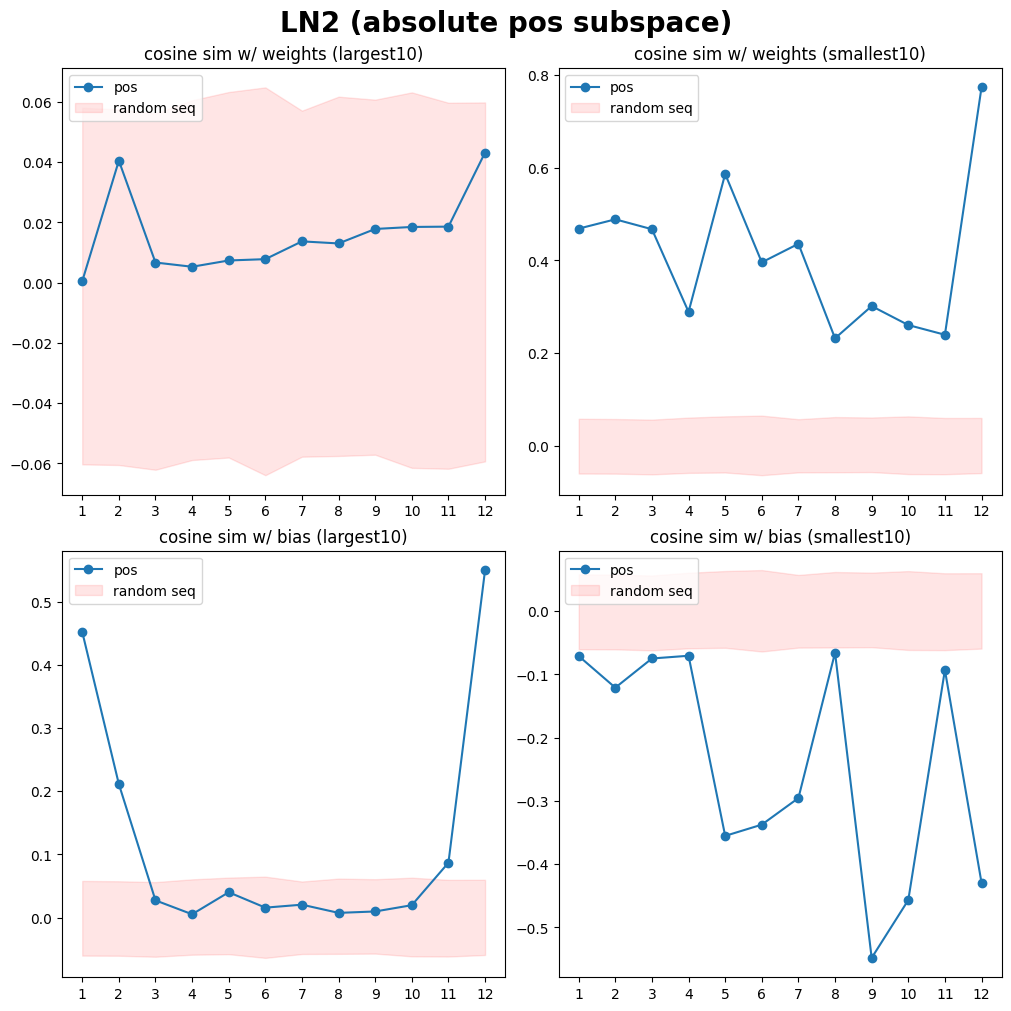

In [11]:
# LN2 weights & bias
sims = np.zeros((12, 6))
for layer in range(12):
    p = pos[layer, 2]

    Vt = np.linalg.svd(p)[-1]
    v = np.abs(Vt[0])

    ln = model.transformer.h[layer].ln_2
    w = ln.weight.numpy(force=True)
    b = ln.bias.numpy(force=True)

    w_L = np.where(w > np.percentile(w, 100 - 10 * 100 / len(w)), w, 0)
    w_S = np.where(w < np.percentile(w, 10 * 100 / len(w)), w, 0)
    b_L = np.where(b > np.percentile(b, 100 - 10 * 100 / len(b)), b, 0)
    b_S = np.where(b < np.percentile(b, 10 * 100 / len(b)), b, 0)

    rs = np.array([cosine_sim(v, np.random.randn(*w.shape)) for _ in range(1000)])
    r_h, r_l = np.percentile(rs, 95, axis=0), np.percentile(rs, 5, axis=0)

    sims[layer] = [
        cosine_sim(v, w_L), cosine_sim(v, w_S),
        cosine_sim(v, b_L), cosine_sim(v, b_S),
        r_h, r_l
    ]

fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
for w_or_b in range(2):
    for l_or_s in range(2):
        ax = axs[w_or_b][l_or_s]
        ax.plot(sims[:, 2*w_or_b+l_or_s], marker="o", label="pos")
        ax.fill_between(np.arange(len(sims)), sims[:, 4], sims[:, 5], label="random seq", color="red", alpha=0.1)
        ax.set_xticks(ticks=np.arange(len(sims)), labels=1 + np.arange(len(sims)))
        ax.legend(loc="upper left")

        name_w_or_b = ["weights", "bias"][w_or_b]
        name_l_or_s = ["largest", "smallest"][l_or_s]
        ax.set_title(f"cosine sim w/ {name_w_or_b} ({name_l_or_s}10)")

plt.suptitle("LN2 (absolute pos subspace)", fontsize=20, fontweight="bold")
plt.savefig("ln2_abs.png")
plt.show()